# KKBOX Position3 Work

Packages

In [1]:
from sklearn import cross_validation, grid_search, metrics, ensemble
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

C:\Users\a0970\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\a0970\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [237]:
members = pd.read_csv(r'C:\Users\a0970\OneDrive\Documents\datas\KKBOX\members.csv')
songs = pd.read_csv(r'C:\Users\a0970\OneDrive\Documents\datas\KKBOX\songs.csv')
train = pd.read_csv(r'C:\Users\a0970\OneDrive\Documents\datas\KKBOX\train.csv')
test  =pd.read_csv(r'C:\Users\a0970\OneDrive\Documents\datas\KKBOX\test.csv')

In [232]:
test  =pd.read_csv(r'C:\Users\a0970\OneDrive\Documents\datas\KKBOX\test.csv')

In [238]:
print('train:',train.shape)
print('test:',test.shape)
print('members:',members.shape)
print('songs:',songs.shape)

train: (7377418, 6)
test: (2556790, 6)
members: (34403, 7)
songs: (2296320, 7)


In [135]:
print('train當中不重複的msno:',len(train.msno.unique()))
print('train當中不重複的song_id:',len(train.song_id.unique()))
print('test當中不重複的msno:',len(test.msno.unique()))
print('test當中不重複的song_id:',len(test.song_id.unique()))

train當中不重複的msno: 30755
train當中不重複的song_id: 359966
test當中不重複的msno: 25131
test當中不重複的song_id: 224753


# Fearture Engineering

train

In [239]:
df_train = pd.merge(train, songs, on='song_id', how='left')

In [240]:
df_train = pd.merge(df_train,members,on='msno',how='left')

In [241]:
df_train.shape

(7377418, 18)

train feature engineering

misssing value

In [142]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
lyricist,3178798,0.430882
gender,2961479,0.401425
composer,1675706,0.227140
source_screen_name,414804,0.056226
genre_ids,118455,0.016056
source_system_tab,24849,0.003368
source_type,21539,0.002920
language,150,0.000020
artist_name,114,0.000015
song_length,114,0.000015


In [143]:
#missing value
for i in df_train.select_dtypes(include=['object']).columns:
    df_train[i][df_train[i].isnull()] = 'unknown'
df_train = df_train.fillna(value=0)

In [163]:
# Create Dates

# registration_init_time
df_train.registration_init_time = pd.to_datetime(df_train.registration_init_time, format='%Y%m%d', errors='ignore')
df_train['registration_init_time_year'] = df_train['registration_init_time'].dt.year
df_train['registration_init_time_month'] = df_train['registration_init_time'].dt.month
df_train['registration_init_time_day'] = df_train['registration_init_time'].dt.day

# expiration_date
df_train.expiration_date = pd.to_datetime(df_train.expiration_date,  format='%Y%m%d', errors='ignore')
df_train['expiration_date_year'] = df_train['expiration_date'].dt.year
df_train['expiration_date_month'] = df_train['expiration_date'].dt.month
df_train['expiration_date_day'] = df_train['expiration_date'].dt.day

In [164]:
# Dates to categoty
df_train['registration_init_time'] = df_train['registration_init_time'].astype('category')
df_train['expiration_date'] = df_train['expiration_date'].astype('category')

# EDA

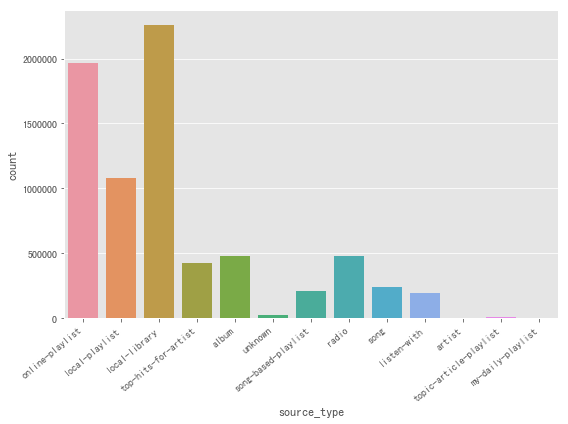

In [145]:
#source_type
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "source_type", data = df_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
# . means the absolutely dir at that time
plt.savefig('./KKBOX/source_type.png')
plt.show()

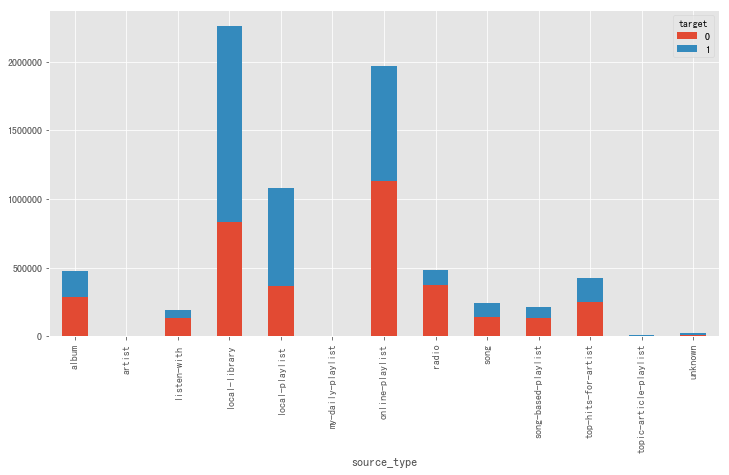

In [147]:
#cross table visualization
ct = pd.crosstab(df_train.source_type, df_train.target)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.savefig('./KKBOX/source_target.png')
plt.show()

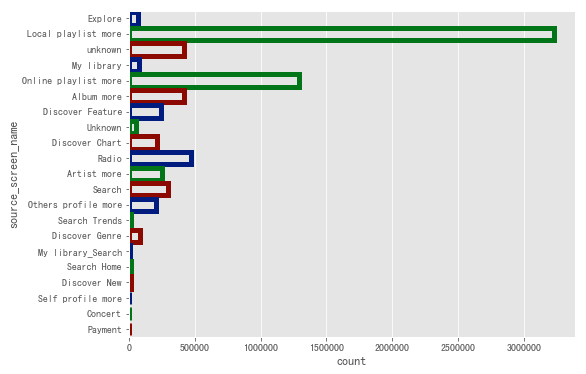

In [148]:
#source_screen_name
plt.figure(figsize = (8, 6))
ax = sns.countplot(y=df_train['source_screen_name'], data=df_train, facecolor=(0, 0, 0, 0),
                    linewidth=5,
                    edgecolor=sns.color_palette("dark", 3))
plt.savefig('./KKBOX/source_screen_name.png')
plt.show()

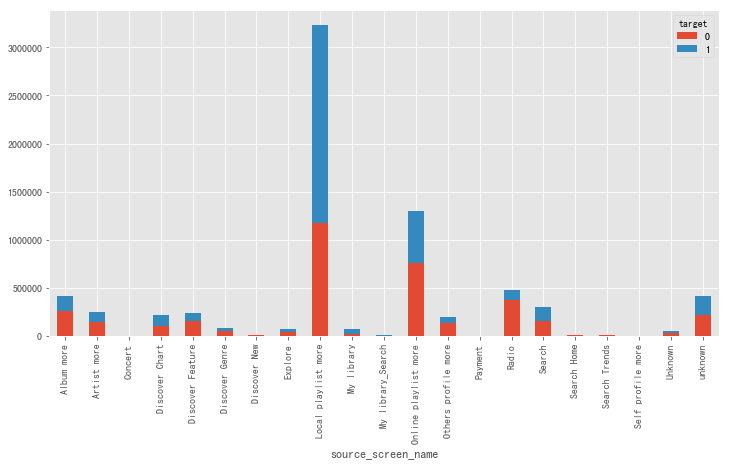

In [149]:
ct = pd.crosstab(df_train.source_screen_name, df_train.target)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.savefig('./KKBOX/source_screen_name_target.png')
plt.show()

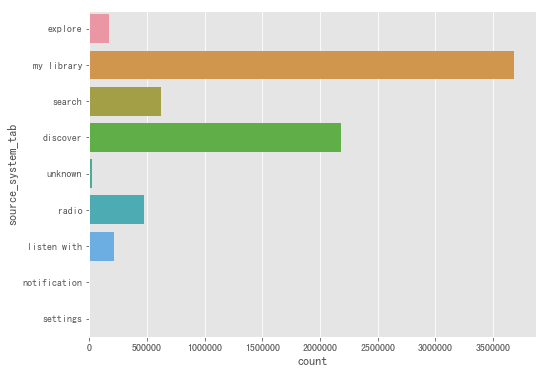

In [150]:
#source_system_tab
plt.figure(figsize = (8, 6))
ax = sns.countplot(y = "source_system_tab", data = df_train)
plt.savefig('./KKBOX/source_system_tab.png')
plt.show()

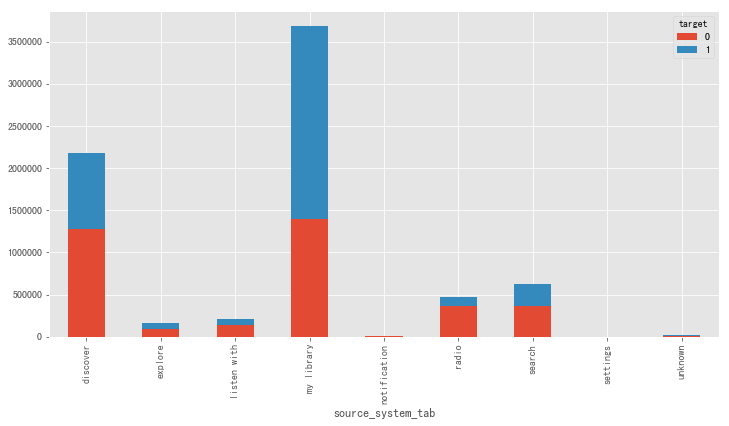

In [151]:
#cross table 
ct = pd.crosstab(df_train.source_system_tab, df_train.target)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.savefig('./KKBOX/source_system_tab_target.png')
plt.show()

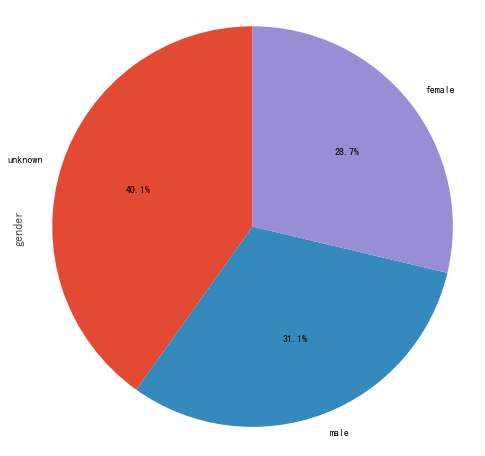

In [152]:
#gender
plt.figure(figsize = (8, 8))
pp = pd.value_counts(df_train.gender)
pp.plot.pie(startangle=90, autopct='%1.1f%%', shadow=False)
plt.axis('equal')
plt.savefig('./KKBOX/gender.png')
plt.show()

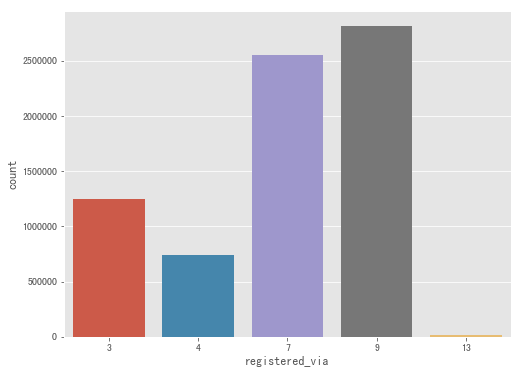

In [153]:
#register_via
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "registered_via", data = df_train)
plt.show()

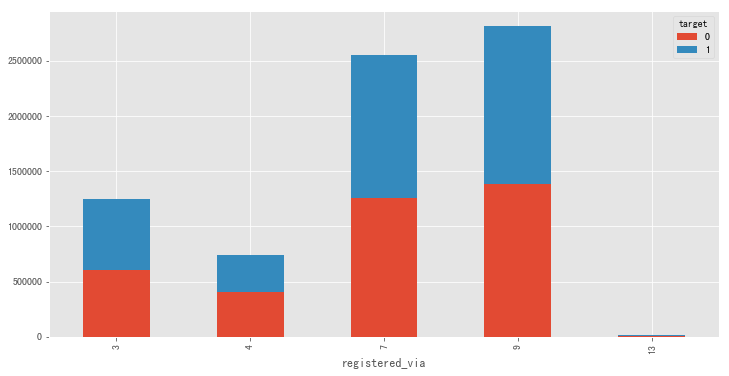

In [154]:
ct = pd.crosstab(df_train.registered_via, df_train.target)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.savefig('./KKBOX/registered_via_target.png')
plt.show()

In [165]:
# Object data to category
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].astype('category')
    
# Encoding categorical features
for col in df_train.select_dtypes(include=['category']).columns:
    df_train[col] = df_train[col].cat.codes

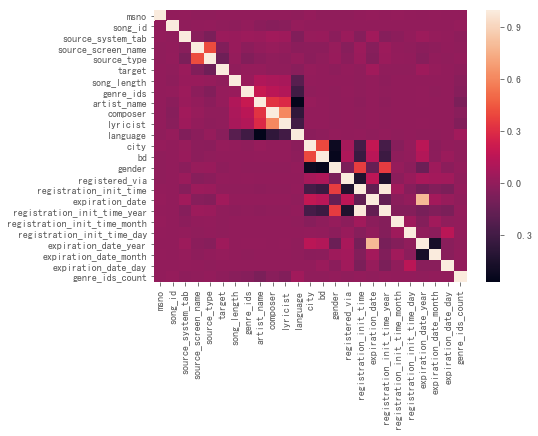

In [52]:
plt.figure(figsize=[7,5])
sns.heatmap(df_train.corr())
plt.show()

In [166]:
# Drop columns
df_train = df_train.drop(['expiration_date', 'lyricist'], 1)

model training

In [214]:
df_trains= df_train

In [171]:
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df_trains[df_trains.columns[df_trains.columns != 'target']], df_trains.target)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [172]:
df_plot = pd.DataFrame({'features': df_trains.columns[df_trains.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

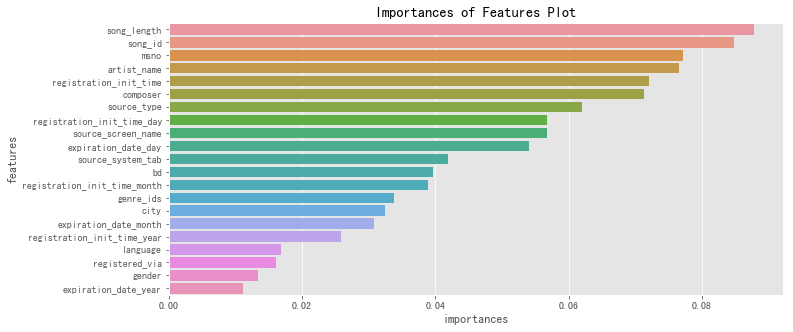

In [173]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [215]:
df_trains = df_trains.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [216]:
df_trains = df_trains.drop('source_system_tab',1)

In [217]:
df_trains.insert(8,'bd',df_train['bd'])

In [219]:
df_trains.insert(10,'registration_init_time_month',df_train['registration_init_time_month'])

In [221]:
# Train & Test split
target = df_trains.pop('target')
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df_trains, target, test_size = 0.2)

In [65]:
# Create model

model = xgb.XGBClassifier()

# Create parameters grid

parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

# Strategy of cross validation

cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 3, test_size = 0.3)

# Create Grid search Strategy

grid_cv = grid_search.RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Fit model by Grid

grid_cv.fit(train_data, train_labels)
grid_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [118]:
# Create model
model_01 = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)
model_01.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [90]:
model_05 = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)
model_05.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [109]:
model_all = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)
model_all.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

10% data

In [119]:
predict_labels = model_01.predict(test_data)

In [120]:
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.68      0.63      0.65     43564
          1       0.66      0.71      0.69     44951

avg / total       0.67      0.67      0.67     88515



50% data

In [91]:
predict_labels = model_05.predict(test_data)

In [92]:
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.69      0.65      0.67    216888
          1       0.69      0.72      0.70    226120

avg / total       0.69      0.69      0.69    443008



100% data

In [222]:
predict_labels = model_all.predict(test_data)

In [224]:
p = model_all.predict_proba(test_data)[:,1]

In [225]:
p

array([0.83434564, 0.35387352, 0.7810359 , ..., 0.33948165, 0.5868817 ,
       0.79722834], dtype=float32)

In [111]:
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.70      0.66      0.68    434407
          1       0.69      0.73      0.71    451637

avg / total       0.70      0.70      0.70    886044



base line

In [98]:
print(metrics.classification_report([1]*len((predict_labels)), predict_labels))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.54      0.70    443008

avg / total       1.00      0.54      0.70    443008



In [99]:
print(metrics.classification_report([0]*len((predict_labels)), predict_labels))

             precision    recall  f1-score   support

          0       1.00      0.46      0.63    443008
          1       0.00      0.00      0.00         0

avg / total       1.00      0.46      0.63    443008



In [104]:
Counter(predict_labels)

Counter({1: 238522, 0: 204486})

In [245]:
df_test.shape

(2556790, 18)

test

In [250]:
df_test = pd.merge(test, songs, on='song_id', how='left')


In [251]:
df_test = pd.merge(df_test,members,on='msno',how='left')

In [252]:
for i in df_test.select_dtypes(include=['object']).columns:
    df_test[i][df_test[i].isnull()] = 'unknown'
df_test = df_test.fillna(value=0)
# Create Dates

# registration_init_time
df_test.registration_init_time = pd.to_datetime(df_test.registration_init_time, format='%Y%m%d', errors='ignore')
df_test['registration_init_time_year'] = df_test['registration_init_time'].dt.year
df_test['registration_init_time_month'] = df_test['registration_init_time'].dt.month
df_test['registration_init_time_day'] = df_test['registration_init_time'].dt.day

# expiration_date
df_test.expiration_date = pd.to_datetime(df_test.expiration_date,  format='%Y%m%d', errors='ignore')
df_test['expiration_date_year'] = df_test['expiration_date'].dt.year
df_test['expiration_date_month'] = df_test['expiration_date'].dt.month
df_test['expiration_date_day'] = df_test['expiration_date'].dt.day
# Dates to categoty
df_test['registration_init_time'] = df_test['registration_init_time'].astype('category')
df_test['expiration_date'] = df_test['expiration_date'].astype('category')
# Object data to category
for col in df_test.select_dtypes(include=['object']).columns:
    df_test[col] = df_test[col].astype('category')
    
# Encoding categorical features
for col in df_test.select_dtypes(include=['category']).columns:
    df_test[col] = df_test[col].cat.codes
# Drop columns
df_tests = df_test.drop(['expiration_date', 'lyricist'], 1)
df_tests = df_tests.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

#correction
df_tests = df_tests.drop('source_system_tab',1)
df_tests.insert(8,'bd',df_test['bd'])
df_tests.insert(10,'registration_init_time_month',df_test['registration_init_time_month'])

In [256]:
ids = df_tests.pop('id')

In [260]:
prob = model_all.predict_proba(df_tests)[:,1]

In [262]:
test_ans = pd.DataFrame({'id': ids, 'target': prob})

In [263]:
test_ans.head()

,id,target
0,0,0.592762
1,1,0.501716
2,2,0.454677
3,3,0.133059
4,4,0.136768


In [264]:
test_ans.to_csv('submission.csv', index=False)

線性回歸